In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

# Set up GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load Labels
labels_csv = pd.read_csv("labels.csv")
filenames = ["train/" + id_ + ".jpg" for id_ in labels_csv["id"]]
labels = labels_csv["breed"].values

# Encode labels
le = LabelEncoder()
integer_labels = le.fit_transform(labels)
boolean_labels = to_categorical(integer_labels, num_classes=len(le.classes_))

# Define Features and Target
x = filenames
y = boolean_labels

num_images = 6500  # Adjust as needed

# Split into Train and Validation Sets
tx, vx, ty, vy = train_test_split(x[:num_images], y[:num_images], test_size=0.2, random_state=42)

# Image Processing Functions
img_size = 224

def process_images(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[img_size, img_size])
    image = preprocess_input(image)  # Normalize for ResNet50
    return image

def get_imagelabel(path, label):
    image = process_images(path)
    return image, label

# Define Batch Size
BATCH_SIZE = 44

def create_data_batch(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch

# Create Training and Validation Data Batches
train_data = create_data_batch(tx, ty)
val_data = create_data_batch(vx, vy, valid_data=True)

# Define Model
def create_resnet_model(input_shape=[224, 224, 3], output_shape=len(le.classes_)):
    # Load ResNet50 model without the top layer
    resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet.trainable = True

    # Fine-tune the last 10 layers of ResNet
    for layer in resnet.layers[:-10]:
        layer.trainable = False
    
    # Input Layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Apply Data Augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2)
    ])
    augmented_inputs = data_augmentation(inputs)
    
    # Extract Features using ResNet50
    resnet_features = resnet(augmented_inputs)
    
    # Global Average Pooling instead of Flatten
    resnet_pooling = layers.GlobalAveragePooling2D()(resnet_features)
    
    # Dense Layers
    x = layers.Dense(1024, activation='relu')(resnet_pooling)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_shape, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile Model with a lower learning rate
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])
    return model

# Create and Summarize Model
model = create_resnet_model()
model.summary()

# Callbacks: TensorBoard, Early Stopping, and Learning Rate Scheduler
import datetime

def create_tb_callback():
    logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Define Training Function
num_epochs = 100

def train_model():
    tensorboard = create_tb_callback()
    with tf.device('/GPU:0'):
        model.fit(x=train_data, epochs=num_epochs, validation_data=val_data, validation_freq=1,
                  callbacks=[tensorboard, early_stopping, lr_scheduler])
    return model

# Save and Load Model
def save_model(model, suffix=None):
    model_dir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = model_dir + (suffix if suffix else "") + ".h5"
    print("Saving model to", model_path + "...")
    model.save(model_path)
    return model_path

def load_model(model_path):
    print("Loading model from:", model_path)
    model = tf.keras.models.load_model(model_path)
    return model


# Train Full Model with All Data
full_data = create_data_batch(x, y)
full_model = create_model()
full_model_tb = create_tb_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
full_model.fit(full_data, epochs=num_epochs, callbacks=[full_model_tb, full_model_early_stopping])
save_model(full_model, suffix='full_images')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                           

'models\\20241015-040339full_images.h5'

In [30]:
# Process Test Data
test_path = 'test/'
test_filenames = [test_path + file_name for file_name in os.listdir(test_path)]
test_data = create_data_batch(test_filenames, test_data=True)
test_predictions = full_model.predict(test_data, verbose=1)

236/236 [==============================] - 31s 126ms/step


In [31]:
# Prepare Submission File
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df[list(unique_breeds)] = test_predictions
preds_df.to_csv("Submission_resnet.csv", index=False)

In [32]:
# Display User Images and Predictions
us_path = "user images/"
us_filenames = [us_path + fname for fname in os.listdir(us_path)]
us_data = create_data_batch(us_filenames, test_data=True)
us_pred = full_model.predict(us_data)
us_pred_labels = [unique_breeds[np.argmax(us_pred[i])] for i in range(len(us_pred))]

1/1 [==============================] - 0s 297ms/step


In [33]:
us_images = []
for img in us_data.unbatch().as_numpy_iterator():
    us_images.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


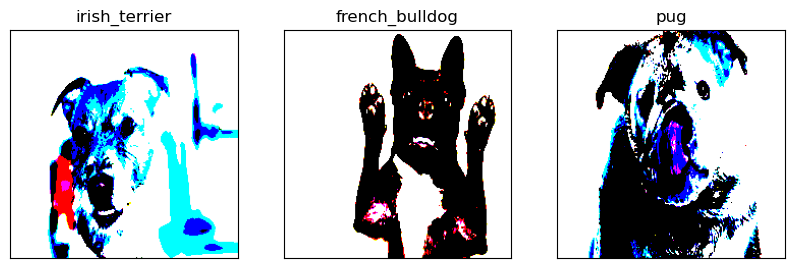

In [34]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(us_images):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(us_pred_labels[i])
    plt.imshow(img)
plt.show()